### Note: To see plotly data visualizations, please copy the <a href="https://github.com/anujs1/data-oa/blob/main/main.ipynb">GitHub file path</a> and run in <a href="https://nbviewer.org">nbviewer.org</a>
**Link: <a href="https://nbviewer.org/github/anujs1/data-oa/blob/main/main.ipynb?flush_cache=true">nbviewer.org/github/anujs1/data-oa/blob/main/main.ipynb</a>**

#### Introduction

In this notebook, I examine how we can use financial complaints to predict whether a consumer will dispute their resolution. Disputes can often be a time-consuming and expensive process with high opportunity costs, and building a model to predict when these disputes may occur will help financial institutions offer their best resolution in their first try and therefore save resources.

#### Initialize and Clean Data

Import libraries and disable warnings

In [ ]:
%pip install xgboost
%pip install plotly
%pip install wordcloud

import plotly.express as px
import plotly.io as pio
import wordcloud as cloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'notebook_connected'

%matplotlib inline

Import data and view first five rows

In [2]:
df = pd.read_csv('consumer_complaints.csv', parse_dates = ['date_received', 'date_sent_to_company'], low_memory = False)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,2013-09-18,Closed with explanation,Yes,No,510473
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,2013-08-30,Closed with explanation,Yes,Yes,510326
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,2013-08-30,Closed with explanation,Yes,Yes,511067


Before generating any insights, it is important to clean the data of any information that may hinder visualizations or conclusions.

View the amount of empty rows for each individual column. Which features are too sparse to generate strong insights into consumer disptues?

In [3]:
df.isna().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

Some zipcodes are improperly formatted, such as '95XXX', and cannot be converted to integers. Replace these zipcodes with NaN, so that the entire column can be treated as a numerical feature and the true number of missing values are accounted for.

In [4]:
faulty_zipcodes = 0
for i in range(len(df['zipcode'])):
    try:
        int(df['zipcode'][i])
    except:
        faulty_zipcodes += 1 # Increment counter for improperly formatted zipcodes
        df['zipcode'][i] = np.NaN # Set the improperly formatted zipcode to NaN

print(f"There are {faulty_zipcodes} improperly formatted or NaN zipcodes")

There are 82069 improperly formatted or NaN zipcodes


Find the features consisting of more than 10% NaN values. I set 10% to be our NaN threshold, as any more could lead to improperly imputed data that harms our insights and model performance.

In [5]:
drop_threshold = 0.10
cols_na_counts = df.isna().mean(axis=0) # Get the NaN counts for each column
cols_over_dt = cols_na_counts[cols_na_counts >= drop_threshold] # Filter the columns to only include those with > 10% NaN
cols_over_dt

sub_product                     0.284774
sub_issue                       0.617557
consumer_complaint_narrative    0.879836
company_public_response         0.846887
zipcode                         0.147618
tags                            0.859775
consumer_consent_provided       0.777936
dtype: float64

Drop features and reformat categorical features into numerical features so that they can be interpreted by a classification model.

Drops due to unhelpfulness (if we use the ML model for our institution, these categories are either unhelpful or will create data leakage):
* complaint_id
* company

Drops due to high NaN counts (> 10%):
* sub_product
* sub_issue
* consumer_complaint_narrative
* company_public_response
* zipcode
* tags
* consumer_consent_provided

Data reformatted:
* Yes/No columns converted from str to int: 'No' -> 0 and 'Yes' -> 1
* company_response_to_consumer converted from str to int: 'Closed' -> 1, otherwise str -> 0
* date_received and date_sent_to_company converted from DateTime to int as its ordinal value

In [6]:
# Drop data
col_drops = list(cols_over_dt.index) + ['company', 'complaint_id']
df = df.drop(col_drops, axis=1)

# Reformat data
df = df.replace(['Yes', 'No'], [1, 0])

# Change all types of closed cases to 1, unclosed cases to 0 (converts to numerical feature)
case_col = 'company_response_to_consumer'
df.loc[df[case_col].str.contains('Closed'), case_col] = 1
df.loc[df[case_col] != 1, case_col] = 0

# Change all datetime objects to ordinal value of date (converts to numerical feature)
date_cols = ['date_received', 'date_sent_to_company']
for date_col in date_cols:
    df[date_col] = df[date_col].apply(pd.Timestamp.toordinal)

Drop NaN rows for state column

In [7]:
df = df.dropna(subset=['state'])
df.isna().sum()

date_received                   0
product                         0
issue                           0
state                           0
submitted_via                   0
date_sent_to_company            0
company_response_to_consumer    0
timely_response                 0
consumer_disputed?              0
dtype: int64

#### Data Visualization

Functions to create a new DataFrame containing the frequency values of a given feature, as well as the proportion of a given feature that was disputed. I created these functions to be modular and able to generate a DataFrame for any feature. 

In [8]:
dispute_category = ''
# Returns a new 'consumer_disputed?' column with the count of a given category that was disputed
def get_disputes(row):
    return df[(df['consumer_disputed?'] == 1) & (df[dispute_category] == row[dispute_category])]['consumer_disputed?'].sum()

# Returns a new DataFrame with the count of a given category that was disputed and not disputed in separate rows
def get_frequency_df(dispute_category: str, data: pd.DataFrame = df) -> pd.DataFrame:
    cat_df = data[[dispute_category, 'issue', 'consumer_disputed?']].groupby([dispute_category]).count().reset_index()
    cat_df['consumer_disputed?'] = cat_df.apply(get_disputes, axis=1)
    cat_df['percent_disputes'] = cat_df.apply(lambda row: (row['consumer_disputed?'] / row['issue']) * 100, axis=1)
    return cat_df

Create a scatterplot to frequency and dispute rate of each product

In [10]:
dispute_category = 'product'
product_df = get_frequency_df(dispute_category)

fig = px.scatter(
    product_df,
    x='consumer_disputed?',
    y='percent_disputes',
    size='issue',
    color=dispute_category,
    title='Product vs Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        'product': 'Product',
        'issue': 'Total Complaints',
    },
    range_x=[0, 45000],
    hover_name='product',
)
fig.show('notebook_connected')

It appears that mortgages are the most frequent complaint product, AND have the highest rate of disputes. On the other hand, although credit reporting has a fair amount of complaints (~15,000), it has a low rate of disputes compared to the rest of the products.

Create a cloropleth to visualize the states with the highest rates of disputed claims

In [11]:
dispute_category = 'state'

state_abbr = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
    'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
    'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]

# Filter the data set to only include US states
usa_df = df[df[dispute_category].isin(state_abbr)][[dispute_category, 'issue', 'consumer_disputed?']]
usa_df = get_frequency_df(dispute_category, usa_df)

fig = px.choropleth(
    usa_df,
    locations=dispute_category,
    locationmode="USA-states",
    scope="usa",
    color='percent_disputes',
    color_continuous_scale="rdylgn_r",
    title='State vs Percentage of Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        dispute_category: 'State',
    },
)
fig.show('notebook_connected')

Consumers in the west coast seem to be more likely to dispute their complaint resolutions compared to the rest of the country, followed by the east coast. The middle region of the country, highlighted by New Mexico and South Dakota, have much lower dispute rates.

Create bar graph to visualize proportions of each submition method that was disputed

In [12]:
dispute_category = 'submitted_via'

sub_df = get_frequency_df(dispute_category)

fig = px.bar(
    sub_df,
    x=dispute_category,
    y='percent_disputes',
    title='Submition Method vs Percentage of Consumer Disputes',
    labels={
        'consumer_disputed?': 'Consumer Disputes',
        'percent_disputes': 'Percent of Complaints Disputed',
        dispute_category: 'Submitted Via',        
    },
    range_y=[13, 23]
)
fig.show('notebook_connected')

Web submissions, which also happen to be the most common form of complaint submission, have the highest dispute rate. On the other hand, postal mail submissions, which are one of the least common methods for complaint submissions, have the lowest dispute rates.

A trend that I notice is that instant and non-verbal forms of communication (web, fax, email) have higher dispute rates than slower, non-anonymous methods of submission (referral, phone, postal mail). Could the attributes of the latter category create a barrier that discourages consumers from disputing the resolutions of their claims?

Use NLP and sentiment analysis to create a word cloud that visualizes the most common issues within complaints

(-0.5, 399.5, 199.5, -0.5)

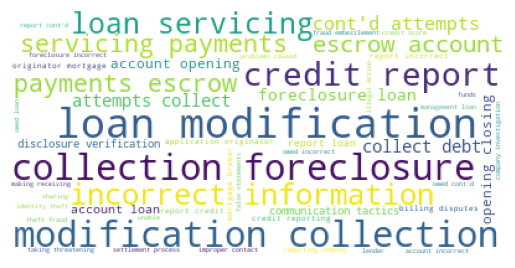

In [13]:
df.issue = df.issue.apply(str.lower)
words = ''
for issue in df.issue:
    words += issue + ' '

wordcloud = cloud.WordCloud(
    stopwords=set(cloud.STOPWORDS),
    min_font_size=5,
    background_color='white',
).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

Use NLP and sentiment analysis to create a word cloud that visualizes the most common issues within *disputed* complaints

(-0.5, 399.5, 199.5, -0.5)

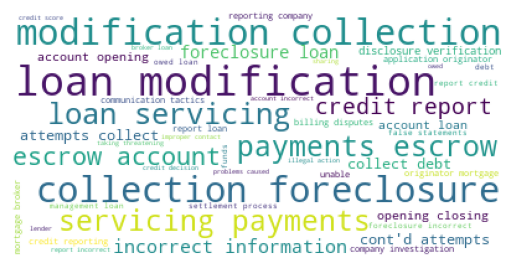

In [14]:
word_df = df
word_df = word_df[word_df['consumer_disputed?'] == 1] # Filter the df to only include disputed claims
words = ''
for issue in word_df.issue:
    words += issue + ' '

wordcloud = cloud.WordCloud(
    stopwords=set(cloud.STOPWORDS),
    min_font_size=5,
    background_color='white',
).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

A form of modification (loan, collection) is the most common issue found in sentiment analysis. Credit reports seem to be less common among disputes than all issues. However, servicing payments seems to be an issue that leads to greater disputes.

#### One-Hot Encoding for ML Implementation

Every non-`int` feature has a relatively low number of unique values (< 100). This makes the data a good candidate for one-hot encoding, which creates a new binary column for every unique value of non-`int` columns.

In [15]:
df.nunique()

date_received                   1608
product                           11
issue                             95
state                             62
submitted_via                      6
date_sent_to_company            1557
company_response_to_consumer       2
timely_response                    2
consumer_disputed?                 2
dtype: int64

In [16]:
df = df.infer_objects()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551070 entries, 0 to 553096
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 551070 non-null  int64 
 1   product                       551070 non-null  object
 2   issue                         551070 non-null  object
 3   state                         551070 non-null  object
 4   submitted_via                 551070 non-null  object
 5   date_sent_to_company          551070 non-null  int64 
 6   company_response_to_consumer  551070 non-null  int64 
 7   timely_response               551070 non-null  int64 
 8   consumer_disputed?            551070 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 42.0+ MB


Create one-hot encoded columns and drop the original categorical columns.

In [17]:
categorical_cols = ['product', 'issue', 'state', 'submitted_via']
ohe_df = df
for col in categorical_cols:
    col_ohe = pd.get_dummies(ohe_df[col], prefix=col) # Create new numerical columns off of values in categorical column
    ohe_df = pd.concat((ohe_df, col_ohe), axis=1).drop(col, axis=1) # Add columns to df and drop original categorical column

As seen below, there are only numerical features as all of the categorical columns were encoded into binary features.

In [18]:
ohe_df.head()

,date_received,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,product_Bank account or service,product_Consumer Loan,product_Credit card,product_Credit reporting,product_Debt collection,...,state_WA,state_WI,state_WV,state_WY,submitted_via_Email,submitted_via_Fax,submitted_via_Phone,submitted_via_Postal mail,submitted_via_Referral,submitted_via_Web
0,735110,735114,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,735110,735114,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,735110,735129,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,735110,735110,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,735110,735110,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


#### Logistic Regression Classification Model Creation and Evaluation

Now that the data consists only of numerical features, it can be interpreted by a numerical classification model.

Split the data into 80% training and 20% testing sets

In [19]:
target = 'consumer_disputed?'
X = ohe_df.drop(target, axis=1)
y = ohe_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Create a Logistic Regression classifier, fit the model on the training data, and create a prediction vector on the testing features.

In [20]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Evaluate the raw accuracy of the model by comparing the predicted labels and the actual labels of the testing set

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 79.81%


Without any hyperparameter tuning and customization, an 80% accuracy appears to be reasonably strong! But...

Create a confusion matrix to examine precision and recall of the model

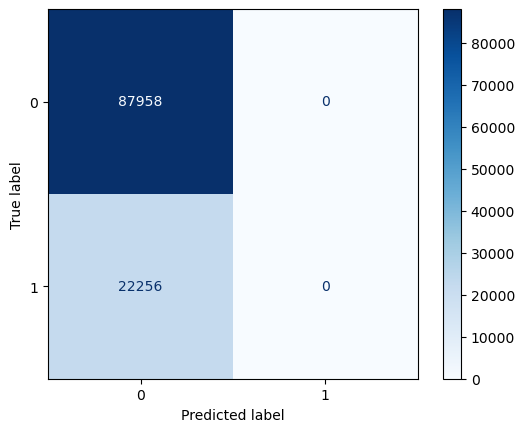

In [22]:
matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

It appears that **every** true consumer dispute is predicted incorrectly as a non-dispute. In the real world, this would mean that the model would predict that the consumer would not dispute the claim resolution every time, making it relatively useless to our financial institution.

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     87958
           1       0.00      0.00      0.00     22256

    accuracy                           0.80    110214
   macro avg       0.40      0.50      0.44    110214
weighted avg       0.64      0.80      0.71    110214



It looks like we have a recall of **0** (!) for true disputes.

Let's try to lower the threshold of our model to increase its recall. See <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/">this website</a> for the math behind how this optimal threshold value was calculated.

In [24]:
from sklearn.metrics import roc_curve, confusion_matrix
yhat = clf.predict_proba(X_test)
y_hat = [i[1] for i in yhat]
fpr, tpr, thresholds = roc_curve(y_test.values, y_hat)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
print(f"Best Threshold: {thresholds[ix]}\nG-Mean: {gmeans[ix]}")

Best Threshold: 0.20192467793497948
G-Mean: 0.5044667432872447


In [25]:
threshold = thresholds[ix]
decisions = (clf.predict_proba(X_test)[:,1] >= threshold).astype(int)
accuracy = accuracy_score(y_test.values, decisions)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 51.43%


As expected, the overall accuracy of the model took a huge hit. But, let's see if it can predict true disputes more accurately.

In [26]:
print(confusion_matrix(y_test.values, decisions))
print(classification_report(y_test, decisions))

[[45814 42144]
 [11382 10874]]
              precision    recall  f1-score   support

           0       0.80      0.52      0.63     87958
           1       0.21      0.49      0.29     22256

    accuracy                           0.51    110214
   macro avg       0.50      0.50      0.46    110214
weighted avg       0.68      0.51      0.56    110214



Now, the recall for true disputes is 49%, which is much greater than our original value but still pretty low. This quick and dirty ML model still needs a lot more tuning and bias reduction before it can be deployed in the real world.

#### Conclusion

Despite our visualizations and insights, our ML model still needs a lot of improvement before it can be implemented in the real world. Still, we can use these insights to inform the decisions we make in our financial institution when dealing with complaints in the future.